This notebook has been prepared based on the homework given in [berkeleydeeprl course](https://github.com/berkeleydeeprlcourse/homework/blob/0015ad14cf155d59fede725f2d783f4683cc8215/sp17_hw/hw2/HW2.ipynb) and https://github.com/dennybritz/reinforcement-learning.
This reviews the two classic methods for solving Markov Decision Processes (MDPs) with finite state and action spaces. We have value iteration (VI) and policy iteration (PI) for a finite MDP, both of which find the optimal policy in a finite number of iterations.

The experiments here use the [Frozen Lake environment](https://gym.openai.com/envs/FrozenLake-v0), a simple gridworld MDP that is taken from gym. In this MDP, the agent must navigate from the start state to the goal state on a 4x4 grid, with stochastic transitions.

In [1]:
# © Ozan Arkan Can, 2018.
using Pkg; for p in ("Gym","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
ENV["GYM_ENVS"]="atari:classic_control:box2d"
using Gym, Random, Printf

In [2]:
env = GymEnv("FrozenLake-v0");

In [3]:
println(env.gymenv[:unwrapped][:__doc__])


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    


In [4]:
Random.seed!(1); seed!(env, 1);
irender(env)=println(render(env; mode="ansi")[:getvalue]())
reset!(env)
irender(env)
for t=1:100
    a = sample(env.action_space)
    ob, rew, done, _ = step!(env, a)
    irender(env)
    if done
        break
    end
end


SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG



In the episode above, the agent falls into a hole after two time steps. Also note the stochasticity on the second step, the Right action is selected, but the agent moves down.

We extract the relevant information from the gym env into the MDP struct below. The env object won't be used any further, we'll just use the mdp object.

In [5]:
mutable struct MDP
    P # state transition and reward probabilities, explained below
    nS # number of states
    nA # number of actions
    desc # 2D array specifying what each grid cell means (used for plotting)
end

#We will modify the original transition matrix whicch allows more stable policies.
#https://github.com/berkeleydeeprlcourse/homework/blob/60b3ef08c2dca3961efb63b32683bb588571f226/sp17_hw/hw2/frozen_lake.py#L89

function inc(row, col, a)
    if a==0 # left
        col = max(col-1,0)
    elseif a==1 # down
        row = min(row+1,3)
    elseif a==2 # right
        col = min(col+1,3)
    else # up
        row = max(row-1,0)
    end
    return (row, col)
end

P = Dict(s => Dict(a => [] for a=1:4) for s=1:16)
desc = map(x->convert(Array, x), env.gymenv[:unwrapped][:desc])
for row=0:3
    for col=0:3
        s = row * 4 + col + 1
        for a=1:4
            li = P[s][a]
            letter = desc[row+1][col+1]
            if occursin(letter, "GH")
                push!(li, (1.0, s, 0))
            else            
                for b in [(a+2)%4+1, a, a%4+1]
                    newrow, newcol = inc(row, col, b-1)
                    newstate = newrow * 4 + newcol + 1
                    newletter = desc[newrow+1][newcol+1]
                    reward = float(newletter == "G")
                    push!(li, (b==a ? 0.8 : 0.1, newstate, reward))
                end
            end
        end
    end
end

mdp = MDP(P, env.gymenv[:unwrapped][:nS], env.gymenv[:unwrapped][:nA],desc);
println("mdp.P is a two-level dict where the first key is the state and the second key is the action.")
println("The 2D grid cells are associated with indices [1, 2, ..., 16] from left to right and top to down, as in")
println("[1 2 3 4\n 5 6 7 8\n 9 10 11 12\n 13 14 15 16]")
println("mdp.P[state][action] is a list of tuples (probability, nextstate, reward).\n")
println("For example, state 1 is the initial state, and the transition information for s=1, a=1 is \nP[1][1] =", mdp.P[1][1], "\n")
println("As another example, state 6 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.")
println("P[6][1] =", mdp.P[6][1], '\n')


mdp.P is a two-level dict where the first key is the state and the second key is the action.
The 2D grid cells are associated with indices [1, 2, ..., 16] from left to right and top to down, as in
[1 2 3 4
 5 6 7 8
 9 10 11 12
 13 14 15 16]
mdp.P[state][action] is a list of tuples (probability, nextstate, reward).

For example, state 1 is the initial state, and the transition information for s=1, a=1 is 
P[1][1] =Any[(0.1, 1, 0.0), (0.8, 1, 0.0), (0.1, 5, 0.0)]

As another example, state 6 corresponds to a hole in the ice, which transitions to itself with probability 1 and reward 0.
P[6][1] =Any[(1.0, 6, 0)]



## Value Iteration

Here, we have the value iteration, which has the following pseudocode:

---
Initialize $V^{(0)}(s)=0$, for all $s$

For $i=0, 1, 2, \dots$
- $V^{(i+1)}(s) = \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$, for all $s$

---

We additionally define the sequence of greedy policies $\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}$, where
$$\pi^{(i)}(s) = \arg \max_a \sum_{s'} P(s,a,s') [ R(s,a,s') + \gamma V^{(i)}(s')]$$

The code returns two lists: $[V^{(0)}, V^{(1)}, \dots, V^{(n)}]$ and $[\pi^{(0)}, \pi^{(1)}, \dots, \pi^{(n-1)}]$

We choose the lower-index action to break ties in $\arg \max_a$. This is done automatically by findmax. This will only affect the "# chg actions" printout below--it won't affect the values computed.

<div class="alert alert-warning">
Warning: We make a copy of your value function each iteration and use that copy for the update--instead of updating the value function in place. 
Updating in-place is also a valid algorithm, sometimes called Gauss-Seidel value iteration or asynchronous value iteration, but it will cause you to get different results than presented here.
</div>

In [6]:
"""
    Inputs:
        mdp: MDP
        gamma: discount factor
        nIt: number of iterations, corresponding to n above
    Outputs:
        (value_functions, policies)
"""
function value_iteration(mdp, gamma, nIt)
    """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length mdp.nS
        
        Returns:
            A vector of length mdp.nA containing the expected value of each action.
    """
    function one_step_lookahead(state, V)
        A = zeros(mdp.nA)
        for a=1:mdp.nA
            for (prob, next_state, reward) in mdp.P[state][a]
                A[a] += prob * (reward + γ * V[next_state])
            end
        end
        return A
    end
    
    println("Iteration | max|V-Vprev| | # chg actions | V[1]")
    println("----------+--------------+---------------+---------")
    
    Vs = [zeros(mdp.nS)] # list of value functions contains the initial value function V^{(0)}, which is zero
    πs = []
    for it=1:nIt
        old_π = length(πs) > 0 ? πs[end] : nothing # \pi^{(it)} = Greedy[V^{(it-1)}]. Just used for printout
        Vprev = Vs[end] # V^{(it)}
        # V: bellman backup on Vprev
        #     corresponding to the math above: V^{(it+1)} = T[V^{(it)}]
        #     array of floats
        V = zeros(mdp.nS)
        for s=1:mdp.nS
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, Vprev)
            best_action_value = maximum(A)
            # Update the value function
            V[s] = best_action_value 
        end
        
        # π: greedy policy for Vprev, 
        #     corresponding to the math above: \pi^{(it)} = Greedy[V^{(it)}]
        #     array of ints
        π = zeros(Int, mdp.nS)
        for s=1:mdp.nS
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            #there might me more than one action with max value
            #chose the first one
            best_action = findmax(A)[2]
            # Always take the best action
            π[s] = best_action
        end
        
        max_diff = maximum(abs.(V - Vprev))
        nChgActions= old_π == nothing ? "N/A" : sum((π .!= old_π))
        println(@sprintf("%4i      | %6.5f      | %4s          | %5.3f", it, max_diff, nChgActions, V[1]))
        push!(Vs, V)
        push!(πs, π)
    end
    return Vs, πs
end

γ=0.95 # we'll be using this same value in subsequent implementations
Vs_VI, πs_VI = value_iteration(mdp, γ, 20);

Iteration | max|V-Vprev| | # chg actions | V[1]
----------+--------------+---------------+---------
   1      | 0.80000      |  N/A          | 0.000
   2      | 0.60800      |    2          | 0.000
   3      | 0.51984      |    2          | 0.000
   4      | 0.39508      |    2          | 0.000
   5      | 0.30026      |    1          | 0.000
   6      | 0.25355      |    0          | 0.254
   7      | 0.10478      |    0          | 0.345
   8      | 0.09657      |    0          | 0.442
   9      | 0.03656      |    0          | 0.478
  10      | 0.02772      |    0          | 0.506
  11      | 0.01111      |    0          | 0.517
  12      | 0.00735      |    0          | 0.524
  13      | 0.00310      |    0          | 0.527
  14      | 0.00190      |    0          | 0.529
  15      | 0.00083      |    0          | 0.530
  16      | 0.00049      |    0          | 0.531
  17      | 0.00022      |    0          | 0.531
  18      | 0.00013      |    0          | 0.531
  19      | 0.0000

In [7]:
println("Reshaped Grid Policy (1=left, 2=down, 3=right, 4=up)")
@show reshape(πs_VI[end], 4, 4)'

Reshaped Grid Policy (1=left, 2=down, 3=right, 4=up)
(reshape(πs_VI[end], 4, 4))' = [2 3 2 1; 2 1 2 1; 3 2 2 1; 1 3 3 1]


4×4 LinearAlgebra.Adjoint{Int64,Array{Int64,2}}:
 2  3  2  1
 2  1  2  1
 3  2  2  1
 1  3  3  1

In [8]:
println("Reshaped Grid Value Function")
@show reshape(Vs_VI[20], 4, 4)'

Reshaped Grid Value Function
(reshape(Vs_VI[20], 4, 4))' = [0.531121 0.470613 0.560417 0.470613; 0.573669 0.0 0.619748 0.0; 0.683138 0.827169 0.81546 0.0; 0.0 0.90106 0.969578 0.0]


4×4 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.531121  0.470613  0.560417  0.470613
 0.573669  0.0       0.619748  0.0     
 0.683138  0.827169  0.81546   0.0     
 0.0       0.90106   0.969578  0.0     

## Policy Iteration

Next we will implement the policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a V^{\pi_{n}}(s,a)$
---

### Policy Evaluation

Here, we implement a function called `policy_eval` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.
Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

In [9]:
"""
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        π: [S] shaped vector representing the policy.
        mdp: mdp.P represents the transition probabilities of the environment.
            mdp.P[s][a] is a list of transition tuples (prob, next_state, reward).
            mpd.nS is a number of states in the environment. 
            mdp.nA is a number of actions in the environment.
        γ: discount factor.
        θ: We stop evaluation once our value function change is less than theta for all states.
    
    Returns:
        Vector of length mdp.nS representing the value function.
"""
function policy_eval(π, mdp, γ=0.95, θ=1e-4)
    # Start with a random (all 0) value function
    V = zeros(mdp.nS)
    while true
        Δ = 0
        # For each state, perform a "full backup"
        for s=1:mdp.nS
            v = 0
            # Look at the possible next actions
            for a in π[s]
                action_prob = 1.0#Deterministic policy
                # For each action, look at the possible next states...
                for  (prob, next_state, reward) in mdp.P[s][a]
                    # Calculate the expected value
                    v += action_prob * prob * (reward + γ * V[next_state])
                end
            end
            # How much our value function changed (across any states)
            Δ = max(Δ, abs(v - V[s]))
            V[s] = v
        end
        # Stop evaluating once our value function change is below a threshold
        if Δ < θ
            break
        end
    end
    return V
end

policy_eval

In [10]:
γ = 0.95
θ = 1e-5
random_policy = rand(1:mdp.nA, mdp.nS)
V = policy_eval(random_policy, mdp, γ, θ);

In [11]:
println("Reshaped Grid Policy (Random) (1=left, 2=down, 3=right, 4=up)")
@show reshape(random_policy, 4, 4)'

Reshaped Grid Policy (Random) (1=left, 2=down, 3=right, 4=up)
(reshape(random_policy, 4, 4))' = [4 2 2 3; 3 4 3 4; 1 1 1 3; 1 2 3 4]


4×4 LinearAlgebra.Adjoint{Int64,Array{Int64,2}}:
 4  2  2  3
 3  4  3  4
 1  1  1  3
 1  2  3  4

In [12]:
println("Reshaped Grid Value Function")
@show reshape(V, 4, 4)'

Reshaped Grid Value Function
(reshape(V, 4, 4))' = [0.00057495 0.000889683 0.00879026 0.0; 5.67121e-5 0.0 0.011455 0.0; 2.21224e-5 0.0336961 0.11179 0.0; 0.0 0.354527 0.895713 0.0]


4×4 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.00057495  0.000889683  0.00879026  0.0
 5.67121e-5  0.0          0.011455    0.0
 2.21224e-5  0.0336961    0.11179     0.0
 0.0         0.354527     0.895713    0.0

In [13]:
"""
    Policy Iteration Algorithm. Iteratively evaluates and improves a policy.
    
    Args:
        mdp: A markov decision process.
        γ: discount factor.
        nIt: number of iteration
        
    Returns: (value_functions, policies)
        
"""
function policy_iteration(mdp, γ, nIt)
    """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length mdp.nS
        
        Returns:
            A vector of length mdp.nA containing the expected value of each action.
    """
    function one_step_lookahead(state, V)
        A = zeros(mdp.nA)
        for a=1:mdp.nA
            for (prob, next_state, reward) in mdp.P[state][a]
                A[a] += prob * (reward + γ * V[next_state])
            end
        end
        return A
    end
    Vs = []
    πs = []
    π_prev = rand(1:mdp.nA, mdp.nS)#start with a randomly initialized policy
    push!(πs, π_prev)
    println("Iteration | # chg actions | V[1]")
    println("----------+---------------+---------")
    
    for it=1:nIt
        π_prev = πs[end]
        Vπ = policy_eval(π_prev, mdp, γ)
        π = zeros(Int, mdp.nS)
        for s=1:mdp.nS
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, Vπ)
            #there might me more than one action with max value
            #chose the first one
            best_action = findmax(A)[2]
            # Always take the best action
            π[s] = best_action
        end
        nChgActions= sum((π .!= π_prev))
        println(@sprintf("%4i      | %6i        | %6.5f", it, nChgActions, Vπ[1]))
        push!(Vs, Vπ)
        push!(πs, π)
    end
    return Vs, πs
end

policy_iteration

In [14]:
γ = 0.95
Vs_PI, πs_PI = policy_iteration(mdp, γ, 20);

Iteration | # chg actions | V[1]
----------+---------------+---------
   1      |     16        | 0.00000
   2      |      1        | 0.45543
   3      |      0        | 0.53115
   4      |      0        | 0.53115
   5      |      0        | 0.53115
   6      |      0        | 0.53115
   7      |      0        | 0.53115
   8      |      0        | 0.53115
   9      |      0        | 0.53115
  10      |      0        | 0.53115
  11      |      0        | 0.53115
  12      |      0        | 0.53115
  13      |      0        | 0.53115
  14      |      0        | 0.53115
  15      |      0        | 0.53115
  16      |      0        | 0.53115
  17      |      0        | 0.53115
  18      |      0        | 0.53115
  19      |      0        | 0.53115
  20      |      0        | 0.53115


In [15]:
println("Reshaped Grid Policy (1=left, 2=down, 3=right, 4=up)")
@show reshape(πs_PI[end], 4, 4)'

Reshaped Grid Policy (1=left, 2=down, 3=right, 4=up)
(reshape(πs_PI[end], 4, 4))' = [2 3 2 1; 2 1 2 1; 3 2 2 1; 1 3 3 1]


4×4 LinearAlgebra.Adjoint{Int64,Array{Int64,2}}:
 2  3  2  1
 2  1  2  1
 3  2  2  1
 1  3  3  1

In [16]:
println("Reshaped Grid Value Function")
@show reshape(Vs_PI[end], 4, 4)'

Reshaped Grid Value Function
(reshape(Vs_PI[end], 4, 4))' = [0.531154 0.470633 0.56043 0.470637; 0.573692 0.0 0.619751 0.0; 0.683153 0.827176 0.815462 0.0; 0.0 0.901063 0.969579 0.0]


4×4 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.531154  0.470633  0.56043   0.470637
 0.573692  0.0       0.619751  0.0     
 0.683153  0.827176  0.815462  0.0     
 0.0       0.901063  0.969579  0.0     

In [20]:
using Plots; default(fmt=:png)

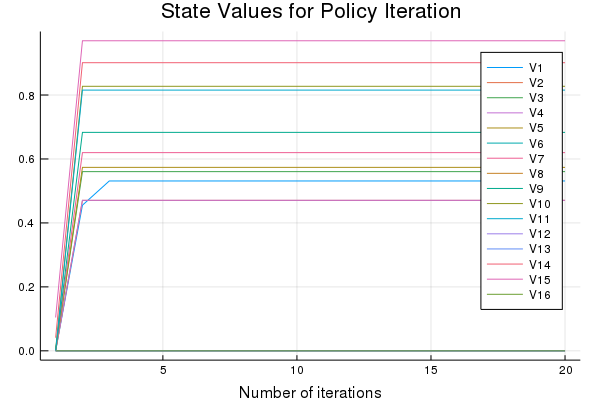

In [18]:
labels = reshape(map(x->"V"*string(x), 1:mdp.nS), 1, mdp.nS)
plot(hcat(Vs_PI...)',label=labels, title="State Values for Policy Iteration")
xlabel!("Number of iterations")

Now we can compare the convergence of value iteration and policy iteration on several states.

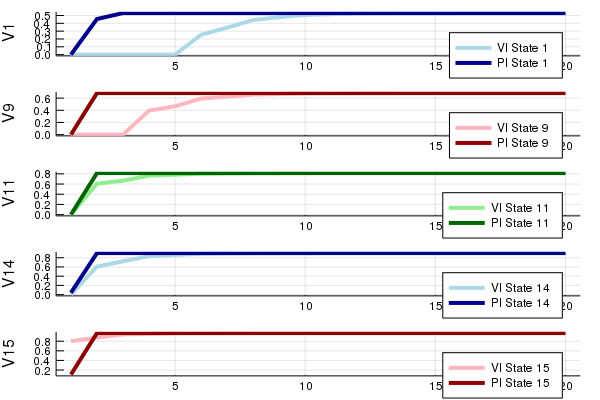

In [19]:
plots = []
pallettes = [:blues, :reds, :greens, :blues, :reds]
states = [1,9,11,14,15]
for i=1:length(states)
    s = states[i]
    push!(plots, plot(hcat(hcat(Vs_VI[2:end]...)'[:, s], hcat(Vs_PI...)'[:, s]),
            labels=["VI State $s" "PI State $s"],
            ylabel="V$s", color_palette=pallettes[i], lw=4)
    )
end
plot(plots...,layout=(5,1))